<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/polyhedron-gdl/halloween-seminar-2023/blob/main/1_notebooks/chapter-06-01.ipynb">
        <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

# Word Embedding

In [1]:
import re
import nltk
import numpy  as np
import pandas as pd

## What are Word Vectorization and Why It is so Important

Word vectorization generically refers to techniques used to convert text into numbers. There may be different numerical representations of the same text. 

Many Machine Learning algorithms and almost all Deep Learning Architectures are incapable of processing *strings* or *plain text* in their raw form. They require numbers as inputs to perform any sort of job, be it classification, regression, etc. in broad terms.


## Bag-of-Words (BOW)

As we have already said, in order to perform machine learning on text, we need to transform our documents into vector representations such that we can apply numeric machine learning. This process is called feature extraction or more simply, vectorization.

We will explore several choices, each of which extends or modifies the base bag-of-words model to describe semantic space. We will look at four types of vector encoding - frequency, one-hot, TF-IDF, and distributed representations - and discuss their implementations in Scikit-Learn, Gensim, and NLTK.

### Sample corpus of text documents

<table><tr>
<td> <img align="left" width="100" height="100" src="./img/text_analytics_with_python.jpg"/> </td>
<td> The following examples are taken from "Text Analytics with Python" by Dipanjan Sarkar (Apress, 2019).     </td>
</tr></table>

[Here](https://github.com/Apress/text-analytics-w-python-2e) you can find the original notebook used in the aforementioned textbook.

The following code is for creating a dataset of text documents along with their corresponding categories using the Python libraries NumPy and Pandas. It creates a Pandas DataFrame called `corpus_df` with two columns: **Document** and **Category**.

In [7]:
corpus = ['The sky is blue and beautiful.',
          'Love this blue and beautiful sky!',
          'The quick brown fox jumps over the lazy dog.',
          "A king's breakfast has sausages, ham, bacon, eggs, toast and beans",
          'I love green eggs, ham, sausages and bacon!',
          'The brown fox is quick and the blue dog is lazy!',
          'The sky is very blue and the sky is very beautiful today',
          'The dog is lazy but the brown fox is quick!'    
]
labels = ['weather', 'weather', 'animals', 'food', 'food', 'animals', 'weather', 'animals']

# creates a Pandas DataFrame named corpus_df. The DataFrame has two columns: 'Document' and 'Category'. 
# Each row in the DataFrame represents a document from the corpus list along with its corresponding 
# category from the labels list.
corpus_df = pd.DataFrame({'Document': corpus, 
                          'Category': labels})
# rearranges the columns in the DataFrame, ensuring that 'Document' comes before 'Category'.
corpus_df = corpus_df[['Document', 'Category']]
corpus_df

,Document,Category
0,The sky is blue and beautiful.,weather
1,Love this blue and beautiful sky!,weather
2,The quick brown fox jumps over the lazy dog.,animals
3,"A king's breakfast has sausages, ham, bacon, e...",food
4,"I love green eggs, ham, sausages and bacon!",food
5,The brown fox is quick and the blue dog is lazy!,animals
6,The sky is very blue and the sky is very beaut...,weather
7,The dog is lazy but the brown fox is quick!,animals


### Simple text pre-processing

The code `nltk.download('stopwords')` is a command used in the Natural Language Toolkit (NLTK) to download a specific NLTK resource, in this case, the "stopwords" dataset.  The **nltk** library stands for the **Natural Language Toolkit**, which is a widely used Python library for working with human language data, particularly in natural language processing (NLP) tasks. "**Stopwords**" are common words in a language (e.g., "the", "and", "is") that are often filtered out or removed from text during text preprocessing for NLP tasks. These words are typically considered to be of low significance for many NLP applications because they occur frequently in the language and do not contribute much to the meaning of the text.

In [8]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Then we define a function `normalize_document` and uses it to preprocess text data. The function takes a text document as input and performs several text preprocessing steps to make the text more suitable for analysis.

In [9]:
# This line initializes an instance of the WordPunctTokenizer from the Natural Language Toolkit (NLTK). 
# It is used for tokenizing text, meaning it splits a text document into individual words or tokens. 
# This tokenizer separates words by whitespace and also handles punctuation.
wpt = nltk.WordPunctTokenizer()
# This line retrieves a list of common English stopwords from the NLTK corpus.
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # This line uses the re.sub function from the Python re module to remove non-alphabetical 
    # characters (i.e., special characters, numbers, and punctuation) from the text. The regular 
    # expression r'[^a-zA-Z\s]' matches anything that is not a letter (a-z or A-Z) or whitespace (\s). 
    # It effectively strips out non-alphabetic characters. The re.I|re.A flags make the regular 
    # expression case-insensitive and handle text with accented characters.
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    # This line converts all the text to lowercase. This is a common text preprocessing step because 
    # it helps ensure consistency and reduces the vocabulary size.
    doc = doc.lower()
    # We remove any leading or trailing whitespace from the document.
    doc = doc.strip()
    # This line uses the WordPunctTokenizer (wpt) to tokenize the document. It splits the text 
    # into a list of individual words or tokens.
    tokens = wpt.tokenize(doc)
    # This line filters out stopwords from the tokenized document. It creates a list of tokens 
    # (filtered_tokens) that exclude any stopwords found in the stop_words list.
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # Finally, this line joins the filtered tokens back together into a single string with spaces 
    # in between. This reconstructed document is now free from non-alphabetical characters, in 
    # lowercase, and with stopwords removed.
    doc = ' '.join(filtered_tokens)
    return doc

# This line wraps the normalize_document function using NumPy's np.vectorize. 
# This makes the function work with NumPy arrays or Pandas DataFrames, allowing 
# you to apply it efficiently to multiple documents in a vectorized manner.
normalize_corpus = np.vectorize(normalize_document)

**Regular Expression Flags**

**re.I - 
re.IGNORECASE**

Perform case-insensitive matching; expressions like [A-Z] will also match lowercase letters. Full Unicode matching (such as Ü matching ü) also works unless the re.ASCII flag is used to disable non-ASCII matches. The current locale does not change the effect of this flag unless the re.LOCALE flag is also used. Corresponds to the inline flag (?i).

**re.A - 
re.ASCII**

Make \\w, \\W, \\b, \\B, \\d, \\D, \\s and \\S perform ASCII-only matching instead of full Unicode matching. This is only meaningful for Unicode patterns, and is ignored for byte patterns. Corresponds to the inline flag (?a).

In [10]:
norm_corpus = normalize_corpus(corpus)
norm_corpus

array(['sky blue beautiful', 'love blue beautiful sky',
       'quick brown fox jumps lazy dog',
       'kings breakfast sausages ham bacon eggs toast beans',
       'love green eggs ham sausages bacon',
       'brown fox quick blue dog lazy', 'sky blue sky beautiful today',
       'dog lazy brown fox quick'], dtype='<U51')

### Frequency Vectors

The simplest vector encoding model is to simply fill in the vector with the frequency of each word as it appears in the document;
In this encoding scheme each document is represented as the multiset of the tokens that compose it and the value for each word position in the vectr is its count;
This representation can either be a straight count encoding or a normalized encoding where each word is weighted by the total number of words in the document.

In **Scikit-Learn** The `CountVectorizer` transformer from the `sklearn.feature_extraction` model has its own internal tokenization and normalization methods. The fit method of the vectorizer expects an iterable or list of strings or file objects, and creates a dictionary of the vocabulary on the corpus. When transform is called, each individual document is transformed into a sparse array whose index tuple is the row (the document ID) and the token ID from the dictionary, and whose value is the count. 

The following code uses the `CountVectorizer` from the `sklearn.feature_extraction.text` module in `scikit-learn` to convert a collection of text documents into a "bag of words" representation. This representation quantifies the frequency of each word in the text data and represents it as a matrix.

In [16]:
# import the CountVectorizer class from scikit-learn. This class is used for text vectorization.
from sklearn.feature_extraction.text import CountVectorizer
# Creating a CountVectorizer Object: The min_df and max_df parameters control the inclusion of words in the vocabulary.
# - min_df: It specifies the minimum document frequency a word must have to be included in the vocabulary. 
#           A value of 0 means that no word is excluded based on its frequency.
# - max_df: It specifies the maximum document frequency a word can have to be included in the vocabulary. 
#           A value of 1 means that all words are included, regardless of their frequency.
cv = CountVectorizer(min_df=0., max_df=1.)
#  This step converts the text documents into a matrix where rows represent documents, and columns represent 
# individual words (or tokens) from the entire corpus. The values in the matrix represent the frequency of 
# each word in each document.
cv_matrix = cv.fit_transform(norm_corpus)
cv_matrix

<8x20 sparse matrix of type '<class 'numpy.int64'>'
	with 42 stored elements in Compressed Sparse Row format>

In [17]:
# cv_matrix is a sparse matrix (a matrix in which most of the elements are zero) that contains the "bag of words" 
# representation of the text documents. Each row corresponds to a document, and each column corresponds to a word. 
# The values in the matrix represent the word frequencies.
cv_matrix = cv_matrix.toarray()
cv_matrix

array([[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0],
       [1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0],
       [1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1],
       [0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0]],
      dtype=int64)

By displaying the document feature vectors in tabular format, it becomes easier to analyze and work with the bag of words representation. The following code retrieve the vocabulary and display the document feature vectors in the form of a Pandas DataFrame. 

The resulting Pandas DataFrame will have the following structure:

- *Rows* represent the individual documents in the corpus.
- *Columns* represent each unique word from the vocabulary.

The values in the DataFrame represent the word frequencies (i.e., how many times each word appears in each document).

In [20]:
# This line retrieves the vocabulary of unique words from the CountVectorizer object cv. The vocabulary consists 
# of all the distinct words (or tokens) that were present in the text documents after preprocessing and tokenization.
# cv.get_feature_names_out() returns a list of these unique words. Each element in the list corresponds to a word 
# found in the corpus.
vocab = cv.get_feature_names_out()
# This line creates a Pandas DataFrame to display the document feature vectors. cv_matrix is the sparse matrix 
# that represents the "bag of words" encoding of the text documents. Each row in this matrix corresponds to 
# a document, and each column corresponds to a unique word from the vocabulary. columns=vocab specifies the 
# column names of the DataFrame, which should be set to the words from the vocabulary.
pd.DataFrame(cv_matrix, columns=vocab)

,bacon,beans,beautiful,blue,breakfast,brown,dog,eggs,fox,green,ham,jumps,kings,lazy,love,quick,sausages,sky,toast,today
0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
2,0,0,0,0,0,1,1,0,1,0,0,1,0,1,0,1,0,0,0,0
3,1,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,1,0
4,1,0,0,0,0,0,0,1,0,1,1,0,0,0,1,0,1,0,0,0
5,0,0,0,1,0,1,1,0,1,0,0,0,0,1,0,1,0,0,0,0
6,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1
7,0,0,0,0,0,1,1,0,1,0,0,0,0,1,0,1,0,0,0,0



### One-Hot Encoding

Because they disregard grammar and the relative position of words in documents, frequency-based encoding methods suffer from the long tail, or Zipfian distribution, that characterizes natural language. As a result, tokens that occur very frequently are orders of magnitude more “significant” than other, less frequent ones. This can have a significant impact on some models (e.g., generalized linear models) that expect normally distributed features. 

A solution to this problem is **one-hot encoding**, a boolean vector encoding method that marks a particular vector index with a value of true (1) if the token exists in the document and false (0) if it does not. In other words, each element of a one-hot encoded vector reflects either the presence or absence of the token in the described text.



**TF - Term Frequency**: Just counting the number of words in each document has 1 issue: it will give more weightage to longer documents than shorter documents. To avoid this, we can use frequency i.e. #count(word) / #Total words, in each document.


### Term Frequency-Inverse Document Frequency

The bag-of-words representations that we have explored so far only describe a document in a standalone fashion, not taking into account the context of the corpus. 
A better approach would be to consider the relative frequency or rareness of tokens in the document against their frequency in other documents. The central insight is that meaning is most likely encoded in the more rare terms from a document.

TF-IDF, term frequency-inverse document frequency, encoding normalizes the frequency of tokens in a document with respect to the rest of the corpus. 
This encoding approach accentuates terms that are very relevant to a specific instance, as shown in Figure, where the token studio has a higher relevance to this document since it only appears there.

The inverse document frequency is a measure of how much information the word provides, that is, whether the term is common or rare across all documents. 
It is the logarithmically scaled inverse fraction of the documents that contain the word, obtained by dividing the total number of documents by the number of documents containing the term, and then taking the logarithm of that quotient: 

\begin{equation}idf(t,D) = \log \frac{N}{\vert \{  d \in D: t \in d\}\vert} \end{equation}  

where the numerator ($N$) is the total number of documents in the corpus and the denominator is the number of documents where the term $t$ appears.

Then tf-idf is calculated as: 

\begin{equation} tfidf(t,d,D) = tf(t,d) \cdot idf(t,D)\end{equation}

A high weight in tf-idf is reached by a high term frequency (in the given document) and a low document frequency of the term in the whole collection of documents; the weights hence tend to filter out common terms.  Since the ratio inside the idf's log function is always greater than or equal to 1, the value of idf (and tf-idf) is greater than or equal to 0. As a term appears in more documents, the ratio inside the logarithm approaches 1, bringing the idf and tf-idf closer to 0.

![image.png](./img/tf-idf-0.png)

A simple example might serve to explain the structure of the TDM more clearly. Assume we have a simple corpus consisting of two documents, Doc1 and Doc2, with the following content:

Doc1 = "I like databases"
Doc2 = "I dislike databases",

then the document-term matrix would be:

![image.png](./img/tf-idf-1.png)

Clearly there is nothing special about rows and columns – we could just as easily transpose them. If we did so, we’d get a term document matrix (TDM) in which the terms are rows and documents columns. One can work with either a DTM or TDM. Using the raw count of a term in a document, i.e. the number of times that term t occurs in document d, is the simplest choice to measure the term frequency $tf(t,d)$. If we denote the raw count by $f_{t,d}$, then the simplest $tf$ scheme is $tf(t,d) = f_{t,d}$. Other possibilities include

- Boolean "frequencies": $tf(t,d) = 1$ if $t$ occurs in $d$ and $0$ otherwise;
- Term frequency adjusted for document length : $f_{t,d} \big/ \text{(number of words in d)}$;
- Logarithmically scaled frequency: $tf(t,d) = \log (1 + f_{t,d})$;
- Augmented frequency, to prevent a bias towards longer documents, e.g. raw frequency divided by the raw frequency of the most occurring term in the document.

![image.png](./img/3_1_text_vectorization_pic_6.png)

Scikit-Learn provides a transformer called the `TfidfVectorizer` in the module called **feature_extraction.text** for vectorizing documents with TF–IDF scores. Under the hood, the `TfidfVectorizer` uses the `CountVectorizer` estimator we used to produce the bag-of-words encoding to count occurrences of tokens, followed by a `TfidfTransformer`, which normalizes these occurrence counts by the inverse document frequency. 

The input for a `TfidfVectorizer` is expected to be a sequence of filenames, file-like objects, or strings that contain a collection of raw documents, similar to that of the `CountVectorizer`. As a result, a default tokenization and preprocessing method is applied unless other functions are specified. The vectorizer returns a sparse matrix representation in the form of `((doc, term), tfidf)` where each key is a document and term pair and the value is the TF–IDF score.

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

# initializes a TfidfVectorizer object.min_df and max_df control the inclusion of terms in the vocabulary. 
# Here, both are set to include all terms. norm='l2' specifies that the TF-IDF vectors should be normalized 
# using the L2 norm (Euclidean norm, sum of squares of vector elements is 1). use_idf=True indicates that 
# inverse document frequency (IDF) weighting should be applied. smooth_idf=True adds 1 to the numerator 
# and denominator of the IDF calculation to avoid 
# division by zero.
tv = TfidfVectorizer(min_df=0., max_df=1., norm='l2',
                     use_idf=True, smooth_idf=True)
tv_matrix = tv.fit_transform(norm_corpus)
tv_matrix = tv_matrix.toarray()

vocab = tv.get_feature_names_out()
pd.DataFrame(np.round(tv_matrix, 2), columns=vocab)

,bacon,beans,beautiful,blue,breakfast,brown,dog,eggs,fox,green,ham,jumps,kings,lazy,love,quick,sausages,sky,toast,today
0,0.00,0.00,0.60,0.53,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.60,0.00,0.0
1,0.00,0.00,0.49,0.43,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.57,0.00,0.00,0.49,0.00,0.0
2,0.00,0.00,0.00,0.00,0.00,0.38,0.38,0.00,0.38,0.00,0.00,0.53,0.00,0.38,0.00,0.38,0.00,0.00,0.00,0.0
3,0.32,0.38,0.00,0.00,0.38,0.00,0.00,0.32,0.00,0.00,0.32,0.00,0.38,0.00,0.00,0.00,0.32,0.00,0.38,0.0
4,0.39,0.00,0.00,0.00,0.00,0.00,0.00,0.39,0.00,0.47,0.39,0.00,0.00,0.00,0.39,0.00,0.39,0.00,0.00,0.0
5,0.00,0.00,0.00,0.37,0.00,0.42,0.42,0.00,0.42,0.00,0.00,0.00,0.00,0.42,0.00,0.42,0.00,0.00,0.00,0.0
6,0.00,0.00,0.36,0.32,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.72,0.00,0.5
7,0.00,0.00,0.00,0.00,0.00,0.45,0.45,0.00,0.45,0.00,0.00,0.00,0.00,0.45,0.00,0.45,0.00,0.00,0.00,0.0


We can see how a new text, not present in the fit sample, is represented in vector form.

In [23]:
new_doc = 'the sky is green today'

pd.DataFrame(np.round(tv.transform([new_doc]).toarray(), 2), 
             columns=tv.get_feature_names_out())

,bacon,beans,beautiful,blue,breakfast,brown,dog,eggs,fox,green,ham,jumps,kings,lazy,love,quick,sausages,sky,toast,today
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.63,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.46,0.0,0.63


## Document Similarity

When you have vectorized your text, we can try to define a distance metric such that documents that are closer together in feature space are more similar. There are a number of different measures that can be used to determine document similarity; 
Several are illustrated in Figure. Fundamentally, each relies on our ability to imagine documents as points in space, where the relative closeness of any two documents is a measure of their similarity.

We can measure vector similarity with cosine distance, using the cosine of the angle between the two vectors to assess the degree to which they share the same orientation. In effect, the more parallel any two vectors are, the more similar the documents will be (regardless of their magnitude).

<!--
<div>
<img src="./img/3_1_text_vectorization_pic_9.png" width="500"/>
</div>
-->
![pic](./img/3_1_text_vectorization_pic_9.png)
*(image source: Bengfort B. et al. "Text Analysis with Python")*

Mathematically, Cosine similarity metric measures the cosine of the angle between two n-dimensional vectors projected in a multi-dimensional space. The Cosine similarity of two documents will range from 0 to 1. If the Cosine similarity score is 1, it means two vectors have the same orientation. The value closer to 0 indicates that the two documents have less similarity.

The mathematical equation of Cosine similarity between two non-zero vectors is: 

\begin{equation} \text{similarity} = \cos(\theta) = \frac{\mathbf{A} \cdot \mathbf{B}}{\left\Vert\mathbf{A}\right\Vert \,\left\Vert\mathbf{B}\right\Vert} = \frac{\sum\limits_{i=1}^n A_iB_i}{\sum\limits_{i=1}^n A_i^2 \sum\limits_{i=1}^n B_i^2} \end{equation}

Let’s see an example of how to calculate the cosine similarity between two text document. The common way to compute the Cosine similarity is to first we need to count the word occurrence in each document. To count the word occurrence in each document, we can use **CountVectorizer** or **TfidfVectorizer** functions that are provided by Scikit-Learn library.

doc_1 = "Data is the oil of the digital economy" 
doc_2 = "Data is a new oil" 

and consider the following frequency matrix

<!--
<img src='./img/tf-idf-2.png'>
-->
![image.png](./img/tf-idf-2.png)

We can write

In [24]:
doc_1 = "Data is the oil of the digital economy" 
doc_2 = "Data is a new oil" 
data = [doc_1, doc_2]

In [25]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer()
vector_matrix = count_vectorizer.fit_transform(data)

Here, is the unique tokens list found in the data.

In [26]:
tokens = count_vectorizer.get_feature_names_out()
tokens

array(['data', 'digital', 'economy', 'is', 'new', 'of', 'oil', 'the'],
      dtype=object)

In [27]:
vector_matrix.toarray()

array([[1, 1, 1, 1, 0, 1, 1, 2],
       [1, 0, 0, 1, 1, 0, 1, 0]], dtype=int64)

In [28]:
def create_dataframe(matrix, tokens):

    doc_names = [f'doc_{i+1}' for i, _ in enumerate(matrix)]
    df = pd.DataFrame(data=matrix, index=doc_names, columns=tokens)
    return(df)

create_dataframe(vector_matrix.toarray(),tokens)

,data,digital,economy,is,new,of,oil,the
doc_1,1,1,1,1,0,1,1,2
doc_2,1,0,0,1,1,0,1,0


In [29]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarity_matrix = cosine_similarity(vector_matrix)
create_dataframe(cosine_similarity_matrix,['doc_1','doc_2'])

,doc_1,doc_2
doc_1,1.000000,0.474342
doc_2,0.474342,1.000000


Let’s check the cosine similarity with `TfidfVectorizer`, and see how it change over `CountVectorizer`.

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer

Tfidf_vect = TfidfVectorizer()
vector_matrix = Tfidf_vect.fit_transform(data)

tokens = Tfidf_vect.get_feature_names_out()
create_dataframe(vector_matrix.toarray(),tokens)

,data,digital,economy,is,new,of,oil,the
doc_1,0.243777,0.34262,0.34262,0.243777,0.000000,0.34262,0.243777,0.68524
doc_2,0.448321,0.00000,0.00000,0.448321,0.630099,0.00000,0.448321,0.00000


In [31]:
cosine_similarity_matrix = cosine_similarity(vector_matrix)
create_dataframe(cosine_similarity_matrix,['doc_1','doc_2'])

,doc_1,doc_2
doc_1,1.000000,0.327871
doc_2,0.327871,1.000000


Here, using `TfidfVectorizer` we get the cosine similarity between doc_1 and doc_2 is 0.32.  Where the `CountVectorizer` has returned the cosine similarity of doc_1 and doc_2 is 0.47. This is because `TfidfVectorizer` penalized the most frequent words in the document such as stopwords.

Now, the **distance** can be defined as 

\begin{equation}
d =1-\mathrm{CosineSimilarity} 
\end{equation}

The intuition behind this is that if 2 vectors are perfectly the same then similarity is 1 (angle=0) and thus, distance is 0 (1-1=0).

**Clustering documents using similarity features**

In [33]:
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(similarity_matrix, 'ward')
pd.DataFrame(Z, columns=['Document\Cluster 1', 'Document\Cluster 2', 
                         'Distance', 'Cluster Size'], dtype='object')

,Document\Cluster 1,Document\Cluster 2,Distance,Cluster Size
0,0.0,1.0,0.950534,2.0


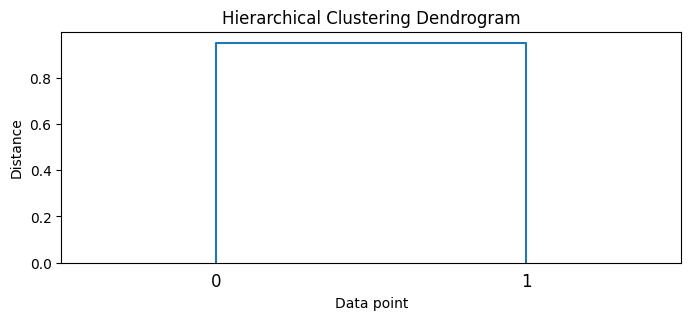

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(8, 3))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data point')
plt.ylabel('Distance')
dendrogram(Z)
plt.axhline(y=1.0, c='k', ls='--', lw=0.5)

In [35]:
from scipy.cluster.hierarchy import fcluster
max_dist = 1.0

cluster_labels = fcluster(Z, max_dist, criterion='distance')
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
pd.concat([corpus_df, cluster_labels], axis=1)

,Document,Category,ClusterLabel
0,The sky is blue and beautiful.,weather,1.0
1,Love this blue and beautiful sky!,weather,1.0
2,The quick brown fox jumps over the lazy dog.,animals,NaN
3,"A king's breakfast has sausages, ham, bacon, e...",food,NaN
4,"I love green eggs, ham, sausages and bacon!",food,NaN
5,The brown fox is quick and the blue dog is lazy!,animals,NaN
6,The sky is very blue and the sky is very beaut...,weather,NaN
7,The dog is lazy but the brown fox is quick!,animals,NaN


## Word Embedding

Humans have always excelled at understanding languages. It is easy for humans to understand the relationship between words but for computers, this task may not be simple. Word embeddings are basically a form of word representation that bridges the human understanding of language to that of a machine. For example, we humans understand the words like king and queen, man and woman, tiger and tigress have a certain type of relation between them but how can a computer figure this out?

The different encoding we have discussed so far is arbitrary as it does not capture any relationship between words. 
It can be challenging for a model to interpret, for example, a linear classifier learns a single weight for each feature. 
Because there is no relationship between the similarity of any two words and the similarity of their encodings, this feature-weight combination is not meaningful.

It should be nice to have representations of text in an n-dimensional space where words that have the same meaning have a similar representation. Meaning that two similar words are represented by almost similar vectors that are very closely placed in a vector space. 

Thus when using word embeddings, all individual words are represented as real-valued vectors in a predefined vector space. 
Each word is mapped to one vector and the vector values are learned in a way that resembles a neural network. Word2Vec is one of the most popular technique to learn word embeddings using shallow neural network. It was developed by Tomas Mikolov in 2013 at Google.

The concept of embeddings arises from a branch of Natural Language Processing called - “Distributional Semantics”. It is based on the simple intuition that: ***Words that occur in similar contexts tend to have similar meanings***. In other words, a word’s meaning is given by the words that it appears frequently with.

### Word2Vec

Word2vec is a method to efficiently create word embeddings by using a two-layer neural network.  
It was developed by Tomas Mikolov, et al. at Google in 2013 as a response to make the neural-network-based training of the embedding more efficient and since then has become the de facto standard for developing pre-trained word embedding. 		  
The input of word2vec is a text corpus and its output is a set of vectors known as feature vectors that represent words in that corpus. 
The Word2Vec objective function causes the words that have a similar context to have similar embeddings. 
Thus in this vector space, these words are really close. Mathematically, the cosine of the angle (Q) between such vectors should be close to 1, i.e. angle close to 0.

Word2vec is not a single algorithm but a combination of two techniques - **CBOW(Continuous bag of words)** and **Skip-gram** model. Both these are shallow neural networks which map word(s) to the target variable which is also a word(s). Both these techniques learn weights which act as word vector representations. 



**CBOW**. 

CBOW predicts the probability of a word to occur **given the words surrounding it**. We can consider a single word or a group of words. But for simplicity, we will take a single context word and try to predict a single target word.
The English language contains almost 1.2 million words, making it impossible to include so many words in our example. So we will consider a small example in which we have only four words i.e. ***live***, ***home***, ***they*** and ***at***. For simplicity, we will consider that the corpus contains only one sentence, that being, ***They live at home***. First, we convert each word into a one-hot encoding form. Also, we'll not consider all the words in the sentence but ll only take certain words that are in a window.

![image.png](./img/word-embedding-1.png)

For example for a window size equal to three, we only consider three words
in a sentence. The middle word is to be predicted and the surrounding two
words are fed into the neural network as context. The window is then slid
and the process is repeated again. Finally, after training the network repeatedly by sliding the window a
shown above, we get weights which we use to get the embeddings as
shown below. Usually, we take a window size of around 8-10 words and have a
vector size of 300.

![image.png](./img/word-embedding-2.png)

#### Implementing a word2vec model using a CBOW (Continuous Bag of Words) neural network architecture

This code process text data from Lewis Carroll's "*Alice's Adventures in Wonderland*", which is part of the Gutenberg corpus available through the Natural Language Toolkit (NLTK) in Python. The code performs several text preprocessing steps to clean and normalize the text data.

In [38]:
# This command instructs NLTK to download the "gutenberg" corpus. The Gutenberg corpus is a collection of publicly 
# available books, primarily in the English language, from Project Gutenberg, a digital library of free eBooks. 
# It includes a wide range of literary works and serves as a valuable resource for text analysis and natural 
# language processing tasks.
nltk.download('gutenberg')
# This command tells NLTK to download the "punkt" tokenizer models. The "punkt" tokenizer models are used for 
# tokenizing (splitting) text into individual words or sentences.
nltk.download('punkt')

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [39]:
# The code imports the gutenberg corpus from the NLTK and the punctuation constant from the string module.
from nltk.corpus import gutenberg
from string import punctuation

# loads the text from the "carroll-alice.txt" file in the Gutenberg corpus and stores it in the book variable. 
# The gutenberg.sents method is used to retrieve the sentences from the book.
book         = gutenberg.sents('carroll-alice.txt') 
#  creates a remove_terms variable, which is a string containing all punctuation marks and the digits 0-9. 
# This variable is intended to be used to remove these characters from the text.
remove_terms = punctuation + '0123456789'

book

[['[', 'Alice', "'", 's', 'Adventures', 'in', 'Wonderland', 'by', 'Lewis', 'Carroll', '1865', ']'], ['CHAPTER', 'I', '.'], ...]

In [40]:
# Goes through each sentence in the book and performs the following operations:
# - It converts each word in the sentence to lowercase.
# - It removes any word that is in the remove_terms string (punctuation and digits).
# The result is a list of lists, where each inner list represents a sentence, and each sentence consists 
# of words in lowercase without punctuation and digits.
norm_doc = [[word.lower() for word in sent if word not in remove_terms] for sent in book]
# Joins the words in each sentence into a single string, using a space as a separator. 
# This creates a list of normalized, space-separated sentences.
norm_doc = [' '.join(tok_sent) for tok_sent in norm_doc]
# The code applies the normalize_corpus function to further normalize the text. The filter(None, ...) part 
# removes any empty sentences that may have been created during normalization.
norm_doc = filter(None, normalize_corpus(norm_doc))
# Filters out sentences that have fewer than 3 words (as determined by splitting the sentence into words using spaces).
norm_doc = [tok_sent for tok_sent in norm_doc if len(tok_sent.split()) > 2]

In [41]:
print('Total lines:', len(book))
print('\nSample line:', book[100])
print('\nProcessed line:', norm_doc[100])

Total lines: 1703

Sample line: ['I', "'", 'm', 'sure', '_I_', 'shan', "'", 't', 'be', 'able', '!']

Processed line: besides oh dear puzzling


In [42]:
# Import 'to_categorical' for one-hot encoding and 'text' and 'sequence' modules for text preprocessing.
from keras.utils import to_categorical
from keras.preprocessing import text
from keras.preprocessing import sequence
# create a tokenizer object by calling text.Tokenizer(). A tokenizer is used to convert text into a 
# sequence of numbers (word indices) and perform various text processing operations.
tokenizer = text.Tokenizer()
# fits the tokenizer on the text data stored in the norm_doc variable. The fit_on_texts method of 
# the tokenizer is used for this purpose. Fitting the tokenizer means that it learns the vocabulary 
# of the text and assigns a unique integer index to each word based on its frequency in the given text.
tokenizer.fit_on_texts(norm_doc)
# After fitting the tokenizer, the code extracts the word-to-index mapping using the word_index attribute 
# of the tokenizer. This mapping is stored in the word2id variable.
word2id = tokenizer.word_index

The result of this code is that you have a `word2id` dictionary where words from the `norm_doc` text data are mapped to unique integer indices. These integer indices can be used for various purposes, such as training machine learning models, including neural networks, that require numerical input. In the context of natural language processing (NLP), this is an essential step as it allows you to represent text data in a format suitable for model training and prediction.

In [43]:
word2id.get('alice')

2

see [here](https://medium.com/@bramblexu/why-tokenizer-in-keras-reserve-word-index-0-33b2c634cca2) for an explanation of padding

In [44]:
word2id['PAD'] = 0

To find a word from an index using the word2id dictionary, you can reverse the dictionary by creating a new dictionary where the keys are the integer indices and the values are the corresponding words. Here's how you can do it in Python using [dictionary comprehension](https://www.datacamp.com/tutorial/python-dictionary-comprehension):

In [45]:
# Reverses the word2id dictionary by using a dictionary comprehension. 
# This line of code swaps the keys and values of word2id, so the resulting id2word dictionary 
# maps integer indices (IDs) to words. It allows you to look up words using their numerical indices.
id2word = {v:k for k, v in word2id.items()}
# This line of code creates a list of lists, where each inner list represents a document in the 
# norm_doc data, and the elements of these inner lists are word indices. It uses list comprehensions 
# and the text.text_to_word_sequence method from Keras to tokenize the text documents and map each 
# word to its corresponding ID using the word2id dictionary.
wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in norm_doc]
# This is the total number of unique words in the vocabulary, which is determined by the length of 
# the word2id dictionary.
vocab_size  = len(word2id)

print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

Vocabulary Size: 2379
Vocabulary Sample: [('said', 1), ('alice', 2), ('little', 3), ('one', 4), ('would', 5), ('know', 6), ('went', 7), ('like', 8), ('could', 9), ('time', 10)]


In [46]:
id2word[2]

'alice'

In [47]:
wids[0]

[2, 337, 669, 1273, 1274]

In [48]:
for n in wids[0]:
    print(id2word[n])

alice
adventures
wonderland
lewis
carroll


In [49]:
# Define the dimension of the word embeddings. In this case, it is set to 100, meaning each word will 
# be represented by a vector of length 100.
embed_size  = 100
# Define the window size for a word embedding algorithm (e.g., Word2Vec). It defines the context window 
# for word prediction.
window_size = 2

The function `generate_context_word_pairs` is a [generator](https://realpython.com/introduction-to-python-generators/) function that takes a text corpus and other parameters related to word embedding using the Word2Vec algorithm. It generates context-word pairs for training a Word2Vec model.

In [50]:
def generate_context_word_pairs(corpus, window_size, vocab_size):
    '''
    Input parameters:
    
    - corpus:      This parameter represents the input text corpus, which is a list of lists, where each inner list 
                   represents a sentence or document, and its elements are the words in that sentence.
    - window_size: It specifies the size of the context window, which determines how many words around a target 
                   word will be considered as context words. The context window size is typically set to a fixed value, 
                   like 2, to capture nearby context.
    - vocab_size:  The vocabulary size represents the total number of unique words in the corpus. This is used to 
                   one-hot encode the label words.
    '''
    # context_length is calculated as window_size * 2, which gives the total number of words in the context 
    # of a target word (before and after the target word).
    context_length = window_size*2
    # This loop iterates over each sentence (list of words) in the corpus
    for words in corpus:
        # the number of words in the current sentence
        sentence_length = len(words)
        # This loop iterates through each word in the sentence along with its index 
        for index, word in enumerate(words):
            # we initialize two empty lists: context_words and label_word. context_words will hold the words 
            # in the context of the target word, and label_word will hold the target word itself.
            context_words = []
            label_word    = []  
            # The context window includes words before and after the target word.
            start         = index - window_size
            end           = index + window_size + 1
            # appends the words in the context window (excluding the target word itself) to the context_words 
            # list using a list comprehension.
            context_words.append([words[i] 
                                 for i in range(start, end) 
                                 if 0 <= i < sentence_length 
                                 and i != index])
            # The target word is appended to the label_word list.
            label_word.append(word)
            # the following line converts context_words into a fixed-size sequence of word indices using 
            # sequence.pad_sequences. This is done because different sentences may have different numbers 
            # of context words, and it's necessary to ensure that they all have the same length. Padding 
            # is added as needed.
            x = sequence.pad_sequences(context_words, maxlen=context_length)
            # The target word (label) is one-hot encoded using to_categorical with a vocabulary size of 
            # vocab_size. This means that the target word is represented as a binary vector where all 
            # elements are zero except for the index corresponding to the word, which is set to one.
            y = to_categorical(label_word, vocab_size)
            # Finally, the function yields the context-word pairs as tuples (x, y), where x is the 
            # context and y is the one-hot encoded label. This allows you to use this generator function 
            # in a training loop for Word2Vec or similar word embedding models. The use of a generator 
            # helps in memory efficiency when working with large corpora.
            yield (x, y)

The following code prints the first 10 context-word pairs with their corresponding context and target words. This is useful for inspecting and verifying the context and target pairs generated by the Word2Vec training data. It can be particularly helpful for debugging and understanding the training data before training a Word2Vec model.

In [51]:
i = 0
# This loop iterates through context-word pairs generated by the generate_context_word_pairs function.
for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
    if 0 not in x[0]:
        print('Context (X):', [id2word[w] for w in x[0]], '-> Target (Y):', id2word[np.argwhere(y[0])[0][0]])
    
        if i == 10:
            break
        i += 1

Context (X): ['alice', 'adventures', 'lewis', 'carroll'] -> Target (Y): wonderland
Context (X): ['alice', 'beginning', 'tired', 'sitting'] -> Target (Y): get
Context (X): ['beginning', 'get', 'sitting', 'sister'] -> Target (Y): tired
Context (X): ['get', 'tired', 'sister', 'bank'] -> Target (Y): sitting
Context (X): ['tired', 'sitting', 'bank', 'nothing'] -> Target (Y): sister
Context (X): ['sitting', 'sister', 'nothing', 'twice'] -> Target (Y): bank
Context (X): ['sister', 'bank', 'twice', 'peeped'] -> Target (Y): nothing
Context (X): ['bank', 'nothing', 'peeped', 'book'] -> Target (Y): twice
Context (X): ['nothing', 'twice', 'book', 'sister'] -> Target (Y): peeped
Context (X): ['twice', 'peeped', 'sister', 'reading'] -> Target (Y): book
Context (X): ['peeped', 'book', 'reading', 'pictures'] -> Target (Y): sister


#### Build CBOW Deep Network Model

Now we can set up a CBOW model for word embeddings. The model takes context words as input, computes the mean of their embeddings, and then predicts the target word using a softmax output layer. It's a simple but effective architecture for learning word representations from a large text corpus.

In [38]:
import keras.backend as K

In Keras, `keras.backend` is a module that provides a backend-agnostic interface for low-level operations in neural networks. It allows Keras to work with multiple backend engines, such as TensorFlow, Theano, and CNTK, without needing to change the high-level code. The `keras.backend` module abstracts the operations, allowing Keras to be used with different computational backends seamlessly.

Some of the functions and utilities you can find in `keras.backend` include:

1. **Tensor operations**: `keras.backend` provides a consistent way to perform tensor operations, such as addition, subtraction, multiplication, and more, across different backend engines.

2. **Math functions**: It includes mathematical functions like `mean`, `sum`, `abs`, and others, which work consistently across different backends.

3. **Variable handling**: You can create and manipulate variables and placeholders with functions like `variable`, `placeholder`, and `update`.

4. **Control flow**: `keras.backend` supports control flow operations like `switch`, `if_else`, and `not_equal`.

5. **Convolution operations**: You can find functions for 2D and 3D convolutions, pooling operations, and more.

6. **Loss functions**: Many commonly used loss functions for different types of tasks, such as classification, regression, and sequence-to-sequence tasks, are available in `keras.backend`.

7. **Activation functions**: Functions like `sigmoid`, `tanh`, `relu`, and others can be found for defining activation functions.

8. **Initialization methods**: `keras.backend` provides functions for initializing model weights, such as `zeros`, `ones`, and `glorot_normal`.

The purpose of `keras.backend` is to ensure that the high-level Keras code can be written independently of the underlying backend engine. When you choose a backend (e.g., TensorFlow or Theano) for your Keras installation, Keras will use the appropriate backend-specific functions from `keras.backend` to perform the operations. This abstraction allows you to write code that is portable across different backend engines.

In [39]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda

# A Sequential model is created and stored in the cbow variable. Sequential models are a linear stack of layers, where you 
#can add layers one after the other.
cbow = Sequential()
# An Embedding layer is added to the model. 
# - input_dim is set to vocab_size, which specifies the size of the vocabulary. This layer is responsible for 
#   learning word embeddings, mapping each word to a dense vector of embed_size dimensions.
# - output_dim is set to embed_size, determining the dimensionality of the word embeddings.
# - input_length is set to window_size*2, indicating the size of the input context window around the target word.
cbow.add(Embedding(input_dim=vocab_size, output_dim=embed_size, input_length=window_size*2))
# The Lambda layer is used to compute the mean of the embeddings within the context window. This step helps 
# aggregate the context information. It takes the mean along axis=1, which means it calculates the mean for 
# each word's embedding vectors. output_shape is set to (embed_size,) to specify the shape of the output.
cbow.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(embed_size,)))
# This layer is the output layer, and it has vocab_size neurons, which corresponds to the size of the vocabulary.
# The activation function used in this layer is 'softmax', which is typical for language modeling tasks like 
# predicting the next word in a sequence.
cbow.add(Dense(vocab_size, activation='softmax'))
# The model is compiled. We specifie the loss function as categorical cross-entropy, which is suitable for 
# multi-class classification tasks like predicting words from a vocabulary. The optimizer is set to 'rmsprop', 
# which is a popular optimization algorithm for training neural networks.
cbow.compile(loss='categorical_crossentropy', optimizer='rmsprop')
print(cbow.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 4, 100)            237900    
                                                                 
 lambda (Lambda)             (None, 100)               0         
                                                                 
 dense (Dense)               (None, 2379)              240279    
                                                                 
Total params: 478179 (1.82 MB)
Trainable params: 478179 (1.82 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


Now we can train our model. The following code iterates through five epochs, processing context-word pairs in each epoch, and updating the model's weights to minimize the loss. The loss indicates how well the model is performing in predicting the target word from its context. After each epoch, it prints the epoch number and the loss, providing an indication of how the model's performance is improving over time through training.

> **Note**: Keras’ `train_on_batch` function accepts a single batch of data, perform backpropagation on it and then update the model parameters. The batch of data can be any size, doesn’t require to define explicitly. When you want to train the model with your own custom rule and want to take the entire control over model training, you can use `Keras.train_on_batch()` function.

In [40]:
nepochs = 25

In [41]:
for epoch in range(1, nepochs):
    loss = 0.
    i = 0
    # This is the inner loop that iterates through context-word pairs generated by the generate_context_word_pairs function. 
    # It uses the previously defined generator to yield these pairs from the training data.
    for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
        i    += 1
        # This line computes the loss for the current batch of context-word pairs and adds it to the running total loss. 
        # cbow is the CBOW model, and train_on_batch is used to perform a single update of the model's weights based on 
        # the batch.
        loss += cbow.train_on_batch(x, y)
        if i % 1000 == 0:
            print('Processed {} (context, word) pairs'.format(i))

    print('Epoch:', epoch, '\tLoss:', loss)
    print()

Processed 1000 (context, word) pairs
Processed 2000 (context, word) pairs
Processed 3000 (context, word) pairs
Processed 4000 (context, word) pairs
Processed 5000 (context, word) pairs
Processed 6000 (context, word) pairs
Processed 7000 (context, word) pairs
Processed 8000 (context, word) pairs
Processed 9000 (context, word) pairs
Processed 10000 (context, word) pairs
Processed 11000 (context, word) pairs
Epoch: 1 	Loss: 85460.81851410866

Processed 1000 (context, word) pairs
Processed 2000 (context, word) pairs
Processed 3000 (context, word) pairs
Processed 4000 (context, word) pairs
Processed 5000 (context, word) pairs
Processed 6000 (context, word) pairs
Processed 7000 (context, word) pairs
Processed 8000 (context, word) pairs
Processed 9000 (context, word) pairs
Processed 10000 (context, word) pairs
Processed 11000 (context, word) pairs
Epoch: 2 	Loss: 84737.6819858551

Processed 1000 (context, word) pairs
Processed 2000 (context, word) pairs
Processed 3000 (context, word) pairs
Pr

Processed 7000 (context, word) pairs
Processed 8000 (context, word) pairs
Processed 9000 (context, word) pairs
Processed 10000 (context, word) pairs
Processed 11000 (context, word) pairs
Epoch: 19 	Loss: 84911.06213909219

Processed 1000 (context, word) pairs
Processed 2000 (context, word) pairs
Processed 3000 (context, word) pairs
Processed 4000 (context, word) pairs
Processed 5000 (context, word) pairs
Processed 6000 (context, word) pairs
Processed 7000 (context, word) pairs
Processed 8000 (context, word) pairs
Processed 9000 (context, word) pairs
Processed 10000 (context, word) pairs
Processed 11000 (context, word) pairs
Epoch: 20 	Loss: 85068.15872458258

Processed 1000 (context, word) pairs
Processed 2000 (context, word) pairs
Processed 3000 (context, word) pairs
Processed 4000 (context, word) pairs
Processed 5000 (context, word) pairs
Processed 6000 (context, word) pairs
Processed 7000 (context, word) pairs
Processed 8000 (context, word) pairs
Processed 9000 (context, word) pairs

The following code snippet extracts the word embeddings (weights) learned by the Continuous Bag of Words (CBOW) model and then creating a DataFrame to display these embeddings. Here's a step-by-step explanation of the code:

1. `weights = cbow.get_weights()[0]`: This line retrieves the model's weights. The `cbow.get_weights()` method returns a list of all trainable parameters of the model, and in this case, we're interested in the first element of that list, which corresponds to the weights of the Embedding layer. The `weights` variable now contains the word embeddings, including both known and unknown words (e.g., padding).

2. `weights = weights[1:]`: This line excludes the first row of the `weights` array. The reason for this is that the first row typically corresponds to the padding token or an out-of-vocabulary token, which is not part of the actual vocabulary. By removing this row, the `weights` array contains only the embeddings for words in the vocabulary.

3. `print(weights.shape)`: This line prints the shape of the `weights` array. It provides information about the number of words in the vocabulary and the dimensionality of the word embeddings.

4. `pd.DataFrame(weights, index=list(id2word.values())[1:]).head()`: This part of the code uses the Pandas library to create a DataFrame from the `weights` array, and it shows the first few rows. Here's what each part of this line does:
   - `pd.DataFrame(weights, ...)` creates a DataFrame with the word embeddings stored in the `weights` array.
   - `index=list(id2word.values())[1:]` sets the row labels of the DataFrame. It uses `id2word` dictionary as a map from word indices to words, and `list(id2word.values())[1:]` extracts the words from the vocabulary (excluding the padding or unknown word at index 0).
   - `.head()` displays only the first few rows of the DataFrame.

The end result of this code is a DataFrame that shows the word embeddings for the words in the vocabulary, which can be useful for visualizing and understanding how the model has represented different words in its embedding space. It's often used for tasks like word similarity and visualizing the relationships between words in the learned embedding space.

In [42]:
weights = cbow.get_weights()[0]
weights = weights[1:]
print(weights.shape)

pd.DataFrame(weights, index=list(id2word.values())[1:]).head()

(2378, 100)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
alice,0.659587,-0.370356,0.033978,-0.382653,-0.605115,-0.488138,0.485675,-0.576641,0.295271,0.391492,...,-0.800001,-0.645227,0.343009,0.122946,0.103425,0.731445,-0.154404,-0.570582,0.501152,-0.021988
little,-0.115173,-0.201434,0.241396,0.139669,0.212713,0.012767,-0.416372,0.439747,-0.238473,0.364920,...,0.176004,0.500476,0.270878,-0.606384,-0.377740,0.018559,-0.631577,0.149897,0.026834,-0.342469
one,0.738218,-0.301046,-0.546976,-0.527589,-0.063052,-0.446419,-0.911571,0.112961,-0.008154,0.292402,...,-0.050305,-0.768602,-0.353555,0.294186,0.348689,-0.131532,0.294962,0.283967,-0.518381,-0.375599
would,-0.434203,0.271913,0.250620,-0.553513,0.203956,-0.267155,-0.403621,-0.162354,0.158466,-0.043063,...,-0.744255,0.736061,-0.376624,0.038636,-0.226928,-0.156947,-0.061064,0.043236,-0.228570,-0.662544
know,0.208025,0.044992,-0.118101,0.133459,0.148801,0.186411,0.192866,0.032639,0.050613,0.077829,...,0.122511,-0.091497,-0.024611,0.092526,-0.100215,-0.119329,-0.009762,0.198300,0.321767,0.357909


Now we can compute the pairwise Euclidean distances between word embeddings to find contextually similar words in the learned embedding space. It uses the `euclidean_distances` function from scikit-learn to calculate the distances. Here's a step-by-step explanation of the code:

1. `from sklearn.metrics.pairwise import euclidean_distances`: This line imports the `euclidean_distances` function from scikit-learn, a Python library for machine learning and data analysis.

2. `distance_matrix = euclidean_distances(weights)`: The `euclidean_distances` function is used to compute the pairwise Euclidean distances between word embeddings stored in the `weights` array. The `weights` array is assumed to be a 2D Numpy array where each row represents the word embedding vector for a specific word. This line computes a square distance matrix where `distance_matrix[i][j]` represents the Euclidean distance between the embeddings of words with indices `i` and `j`.

3. `print(distance_matrix.shape)`: This line prints the shape of the `distance_matrix` to show the dimensions of the distance matrix. It's essentially showing the number of words for which distances have been calculated.

4. `similar_words = {...}`: This part of the code creates a dictionary `similar_words` that will contain contextually similar words for a given set of search terms.

5. The dictionary comprehension `[search_term: ... for search_term in ['cat', 'caterpillar', 'hat', 'alice', 'queen', 'heart']]` loops through a list of search terms, and for each term, it calculates contextually similar words by performing the following steps:

   - `distance_matrix[word2id[search_term]-1]`: This retrieves the row in the distance matrix corresponding to the search term. `word2id[search_term]` is assumed to be a dictionary that maps words to their indices. `-1` is used because indices typically start at 0, and `word2id` might start word indices at 1.

   - `.argsort()[1:6]+1`: This line sorts the indices of the words in ascending order of their Euclidean distances to the search term. `[1:6]` takes the top 5 closest words (excluding the search term itself), and `+1` is used to convert the indices back to start from 1 (assuming they started from 1 in the `word2id` dictionary).

   - `[id2word[idx] for idx in ...]`: For each of the top 5 closest word indices, this code retrieves the corresponding word from the `id2word` dictionary, which maps word indices to words.

The result is a dictionary that associates each search term with a list of contextually similar words. It's a way to explore the words that are semantically close to the given search terms in the learned embedding space. This can be used for tasks like word similarity or for understanding how words are distributed in the embedding space.

In [43]:
from sklearn.metrics.pairwise import euclidean_distances

# compute pairwise distance matrix
distance_matrix = euclidean_distances(weights)
print(distance_matrix.shape)

# view contextually similar words
similar_words = {search_term: [id2word[idx] for idx in distance_matrix[word2id[search_term]-1].argsort()[1:6]+1] 
                   for search_term in ['cat', 'caterpillar', 'hat', 'alice', 'queen', 'heart']}

similar_words

(2378, 2378)


{'cat': ['meant', 'experiment', 'prove', 'hoarse', 'whispers'],
 'caterpillar': ['young', 'interrupt', 'vanished', 'clear', 'railway'],
 'hat': ['cheeks', 'common', 'denial', 'brain', 'askance'],
 'alice': ['better', 'cakes', 'beat', 'occurred', 'finding'],
 'queen': ['croquet', 'play', 'ear', 'knave', 'hearts'],
 'heart': ['remembering', 'grumbled', 'undo', 'race', 'mystery']}

In the last section, we perform dimensionality reduction and visualization of word embeddings using t-Distributed Stochastic Neighbor Embedding (t-SNE). It uses t-SNE to reduce the high-dimensional word embeddings into a two-dimensional space, which allows for the visualization of semantically similar words in a 2D scatter plot. Here's a breakdown of the code:

1. **Import the necessary library**:
   - `from sklearn.manifold import TSNE`: Import the t-SNE implementation from scikit-learn's `manifold` module.

2. **Prepare data**:
   - `words = sum([[k] + v for k, v in similar_words.items()], [])`: This line combines the original search terms with their contextually similar words and flattens them into a single list. `similar_words` is the dictionary created in the previous code snippet.
   - `words_ids = [word2id[w] for w in words]`: This line maps the words to their corresponding word indices using the `word2id` dictionary.
   - `word_vectors = np.array([weights[idx] for idx in words_ids])`: It retrieves the word vectors from the `weights` array based on the word indices and creates a Numpy array of word vectors. The `word_vectors` array now contains the word embeddings for the words of interest.

3. **Print information**:
   - `print('Total words:', len(words), '\tWord Embedding shapes:', word_vectors.shape)`: This line prints the total number of words and the shape of the `word_vectors` array. It provides information about the dimensionality of the word vectors and the number of words being visualized.

4. **t-SNE embedding**:
   - `tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=3)`: Create a t-SNE object with specified parameters:
     - `n_components=2`: Embed the data into a 2D space.
     - `random_state=0`: Set the random seed for reproducibility.
     - `n_iter=10000`: The number of iterations for the optimization process.
     - `perplexity=3`: A parameter controlling the balance between preserving local and global structure in the data.

5. **Fit t-SNE**:
   - `T = tsne.fit_transform(word_vectors)`: Apply t-SNE to reduce the dimensionality of the word vectors and create a 2D representation stored in the `T` array.

6. **Plot the scatter plot**:
   - `plt.figure(figsize=(14, 8))`: Create a figure for the scatter plot with the specified size.
   - `plt.scatter(T[:, 0], T[:, 1], c='steelblue', edgecolors='k')`: Create a scatter plot with `T[:, 0]` as the x-coordinates and `T[:, 1]` as the y-coordinates. The `c` parameter sets the color of the points, and `edgecolors` sets the color of the point boundaries.

7. **Label the points**:
   - `for label, x, y in zip(labels, T[:, 0], T[:, 1]):`: This loop iterates through the labels and coordinates and labels the points in the scatter plot.
   - `plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')`: For each point, it annotates the plot with the word label, slightly offset from the point's coordinates for better visibility.

The result is a scatter plot that visualizes the word embeddings in a 2D space, showing the relationships and similarities between words. This can be a valuable tool for understanding how words are distributed in the word embedding space and for exploring semantic relationships among words.

In [ ]:
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
words_ids = [word2id[w] for w in words]
word_vectors = np.array([weights[idx] for idx in words_ids])
print('Total words:', len(words), '\tWord Embedding shapes:', word_vectors.shape)

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=3)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(word_vectors)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='steelblue', edgecolors='k')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

**Skip-gram**

The Skip-gram model tries to predict the source context words (surrounding words) given a target word (the centre word). The working is conceptually similar to the CBOW, there is just a difference in the architecture of its NN and in the way the weight matrix is generated:	 

![image.png](./img/3_1_text_vectorization_pic_16.png)

# References and Credits



Text Analytics with Python
A Practitioner's Guide to Natural Language Processing
Authors: Sarkar, Dipanjan